# SVM Analysis

## Abstract
The purpose of this exploration was to determine if an AI classification model could be used to determine whether a URL is malicious or not. To perform this analysis, the machine learning tool scikit-learn was used with pandas, matplotlib, and seaborn used for result visualization. The dataset used is by Manu Siddhartha consisting of 650,000 URLs classified into 4 categories: Benign, Defacement, Phishing, and Malware. For the purposes of testing efficiency, a 150,000 portion of the complete dataset were randomly selected at the start of each iteration. The machine learning model used in this portion was SVM (Support Vector Machine), a supervised machine learning algorithm which specializes in classifying data into categories based on predefined data. To obtain predefined data, URLs were analyzed using 7 main features: URL length, Presence in Alexa's Top 1000 domains, HTTP or HTTPS, Frequency of special characters, Digit-to-letter ratio in URL and Domain, IP in Domain, and Shortened Domain. After the analysis, 30% of the analyzed data were randomly selected for model training. The results from multiple iterations showed that SVM had a high probability of correctly identifying a Benign or Defacement URL, but had difficulty identifying Phishing and Malware. The model also showed a high True Negative Rate for all types except Benign. The final overall accuracy of the model showed a success rate of 86-92% in successfully classifying URLs into the appropriate categories; however, this percentage may be biased due to the high amount of Benign URLs in the dataset. A weighted accuracy showed a success rate of about 80%. Overall, this exploration demonstrated that it is possible to know whether a URL is malicious, but it is difficult to surmise the type of maliciousness from the URL alone.

In [4]:
# install dependencies
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install tldextract
%pip install matplotlib
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tldextract as tlde

In [6]:
#load data and check if valid
NUM_SAMPLES = 150000
df = pd.read_csv("malicious_phish.csv")
df = df.sample(n=NUM_SAMPLES, replace=False, random_state=51)
df.head()
df.shape

(150000, 2)

In [7]:
df.isnull().sum()

url     0
type    0
dtype: int64

In [8]:
type_counts = df["type"].value_counts()
type_counts

type
benign        98466
defacement    22188
phishing      21841
malware        7505
Name: count, dtype: int64

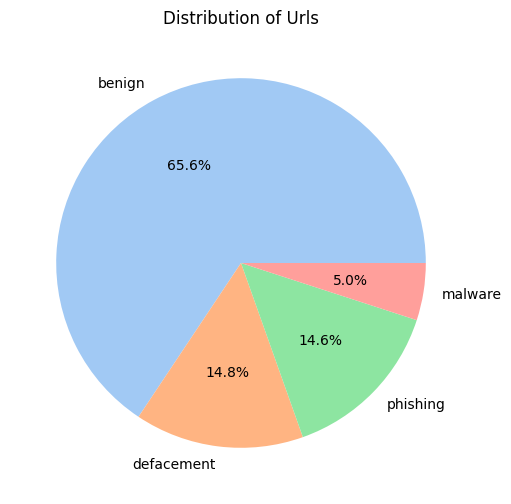

In [9]:
# display distribution
plt.figure(figsize=(6, 6))
plt.pie(
    type_counts,
    labels=type_counts.index,
    autopct="%1.1f%%", # percentage formatting
    colors=sns.color_palette("pastel"),
)
plt.title("Distribution of Urls")
plt.show()


In [10]:
# remove www. from all URLs
df["url"] = df["url"].str.replace("www", "")
df.head()


,url,type
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign
64374,kvha.org/,benign


In [11]:
# create categories and add it to the data frame
url_categories = {
    "benign": 0,
    "phishing": 1,
    "defacement": 2,
    "malware": 3
}

df["category"] = df["type"].map(url_categories)

df.head()

,url,type,category
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0
64374,kvha.org/,benign,0


In [12]:
# Analyze if there exists a relationship between URL length and being a non-benign URL
df["url_length"] = df["url"].apply(len)

df.head()

,url,type,category,url_length
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89
64374,kvha.org/,benign,0,9


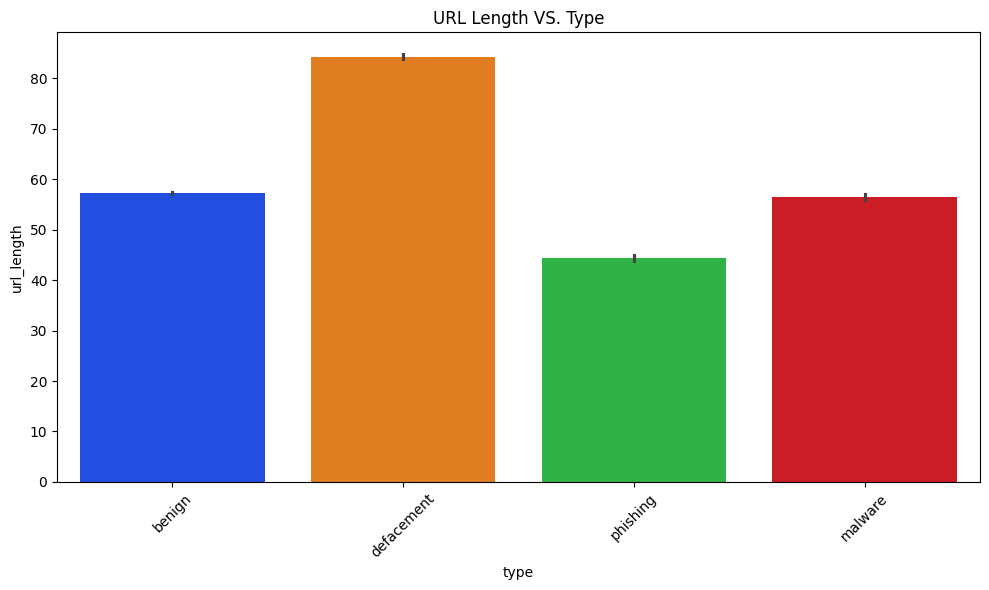

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="type", y="url_length", palette="bright", hue="type")
plt.title("URL Length VS. Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see here that past the cutoff point of a length of about 60, every URL is likely defacement for this dataset.

In [14]:
# Extract domain and suffix from url
def extract_domain(url: str):
    extracted_url = tlde.extract(url)
    return f"{extracted_url.domain}.{extracted_url.suffix}"

df["domain"] = df["url"].apply(extract_domain)

df.head()

,url,type,category,url_length,domain
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net
64374,kvha.org/,benign,0,9,kvha.org


In [15]:
# Check presence in Alexa top 1000 Domains
alexa_top_1000 = []
with open("alexa-top-1000.txt", "r") as f:
    alexa_top_1000 = set([d.strip() for d in f.readlines()])

In [16]:
# 1 if in top 1000 else 0
def check_alexa(domain: str):
    return int(domain in alexa_top_1000)


df["in_alexa_top_1000"] = df["domain"].apply(check_alexa)

df["in_alexa_top_1000"].value_counts()

in_alexa_top_1000
0    128079
1     21921
Name: count, dtype: int64

In [17]:
# Check HTTPS status
# 1 if https exists else 0
def has_https(url):
    return int("https" in url)

df["has_https"] = df["url"].apply(has_https)

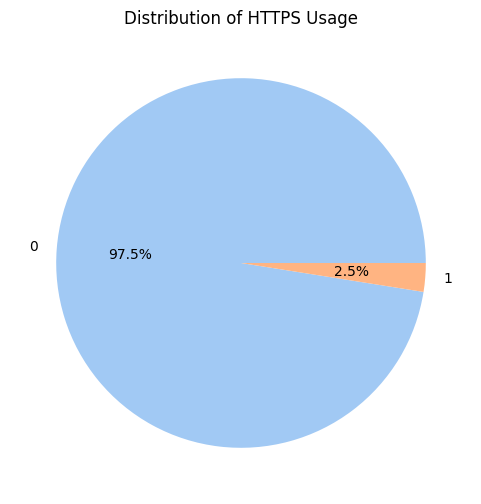

In [18]:
https_counts = df["has_https"].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    https_counts,
    labels=https_counts.index,
    autopct="%1.1f%%",
    colors=sns.color_palette("pastel"),
)
plt.title("Distribution of HTTPS Usage")
plt.show()


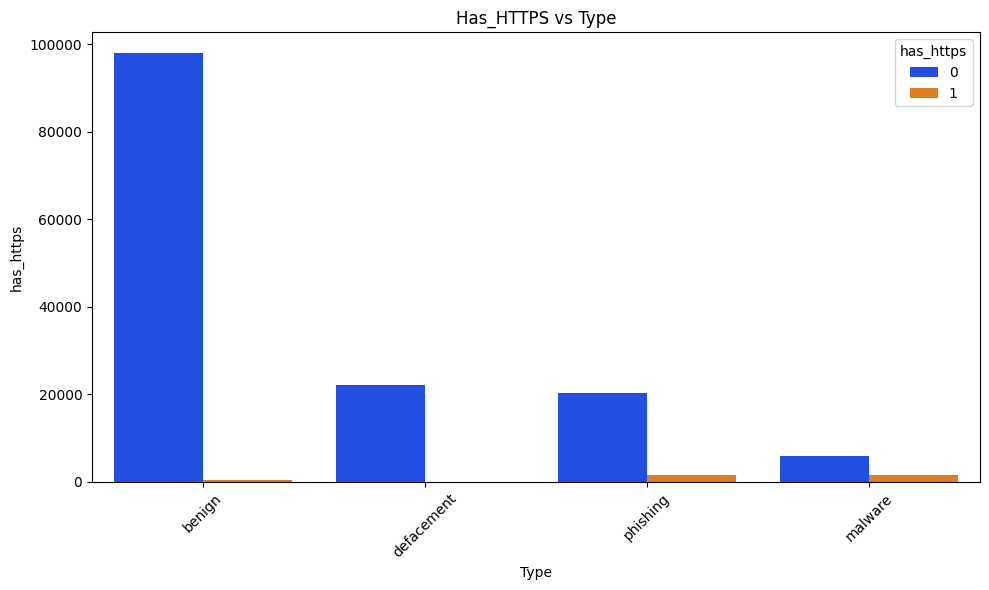

In [19]:
# Relationship between Type and HTTPS Usage
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="type", hue="has_https", palette="bright")
plt.title("Has_HTTPS vs Type")
plt.xlabel("Type")
plt.ylabel("has_https")
plt.xticks(rotation=45)
plt.legend(title="has_https")
plt.tight_layout()
plt.show()


Most sites do not use HTTPS in our dataset and no correlation can be drawn between HTTPS usage and a benign URL. In actuality, having HTTPS for this dataset means that the URL has a higher probability of being malware or phishing.

In [20]:
# Count frequency of special characters
special_characters = ["@", "!", "?", "=", "-", "//", "#", ".", "+", "$", "*", "%", "&"]

def count_characters(url: str, character: str):
    return url.count(character)

for c in special_characters:
    df[c] = df["url"].apply(lambda url: count_characters(url, c))

df.head()

,url,type,category,url_length,domain,in_alexa_top_1000,has_https,@,!,?,=,-,//,#,.,+,$,*,%,&
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com,1,0,0,0,0,0,1,0,0,2,0,0,0,0,0
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com,0,0,0,0,0,0,10,1,0,1,0,0,0,0,0
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net,0,0,0,0,2,6,1,0,0,7,0,0,0,0,5
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net,0,0,0,0,0,0,13,1,0,2,0,0,0,0,0
64374,kvha.org/,benign,0,9,kvha.org,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [21]:
# Digit to letter ratio in URL
def calculate_digit_to_letter_ratio(url):
    digits = sum(c.isdigit() for c in url)
    letters = sum(c.isalpha() for c in url)
    if letters == 0:
        ratio = 0
    else:
        ratio = digits / letters
    return ratio

df["digit_to_letter_ratio_url"] = df["url"].apply(calculate_digit_to_letter_ratio)

df.head()

,url,type,category,url_length,domain,in_alexa_top_1000,has_https,@,!,?,...,-,//,#,.,+,$,*,%,&,digit_to_letter_ratio_url
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com,1,0,0,0,0,...,1,0,0,2,0,0,0,0,0,0.000000
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com,0,0,0,0,0,...,10,1,0,1,0,0,0,0,0,0.070588
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net,0,0,0,0,2,...,1,0,0,7,0,0,0,0,5,0.063694
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net,0,0,0,0,0,...,13,1,0,2,0,0,0,0,0,0.044776
64374,kvha.org/,benign,0,9,kvha.org,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.000000


In [22]:
# Letter to digit ratio in primary domain
df["digit_to_letter_ratio_domain"] = df["domain"].apply(calculate_digit_to_letter_ratio)

df.head()


,url,type,category,url_length,domain,in_alexa_top_1000,has_https,@,!,?,...,//,#,.,+,$,*,%,&,digit_to_letter_ratio_url,digit_to_letter_ratio_domain
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com,1,0,0,0,0,...,0,0,2,0,0,0,0,0,0.000000,0.000000
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0.070588,0.000000
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net,0,0,0,0,2,...,0,0,7,0,0,0,0,5,0.063694,0.000000
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net,0,0,0,0,0,...,1,0,2,0,0,0,0,0,0.044776,0.272727
64374,kvha.org/,benign,0,9,kvha.org,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.000000,0.000000


In [23]:
# Check if URL is an IP address
ip_pattern = (
    r"(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\."
    r"([01]?\d\d?|2[0-4]\d|25[0-5])\/)|"
    r"(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\."
    r"([01]?\d\d?|2[0-4]\d|25[0-5])\/)|"
    r"((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)"
    r"(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|"
    r"([0-9]+(?:\.[0-9]+){3}:[0-9]+)|"
    r"((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)"
)

def has_ip_address(url: str):
    # re.I = ignore case
    return int(re.search(ip_pattern, url, flags=re.I) is not None) 

df["has_ip"] = df["url"].apply(has_ip_address)


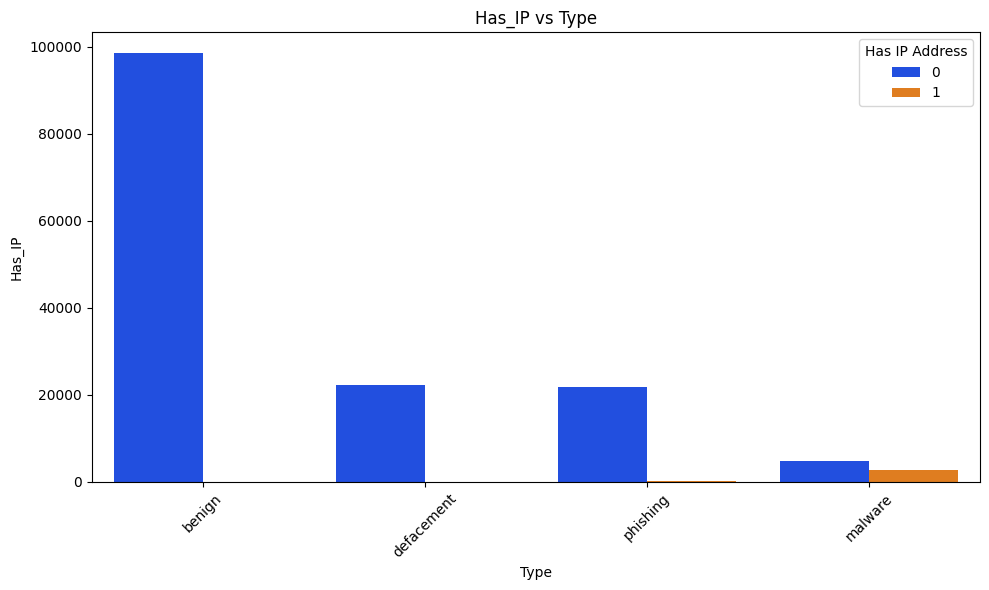

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="type", hue="has_ip", palette="bright")
plt.title("Has_IP vs Type")
plt.xlabel("Type")
plt.ylabel("Has_IP")
plt.xticks(rotation=45)
plt.legend(title="Has IP Address")
plt.tight_layout()
plt.show()


Having only an IP address has a strong correlation with being malware.

In [25]:
# Check if URL has been shortened by a service
shortening_pattern = (
    r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|"
    r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|"
    r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|"
    r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|"
    r"db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|"
    r"q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|"
    r"x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|"
    r"tr\.im|link\.zip\.net"
)


def has_shortening_service(url):
    return int(re.search(shortening_pattern, url, flags=re.I) is not None)

df["shortened"] = df["url"].apply(has_shortening_service)

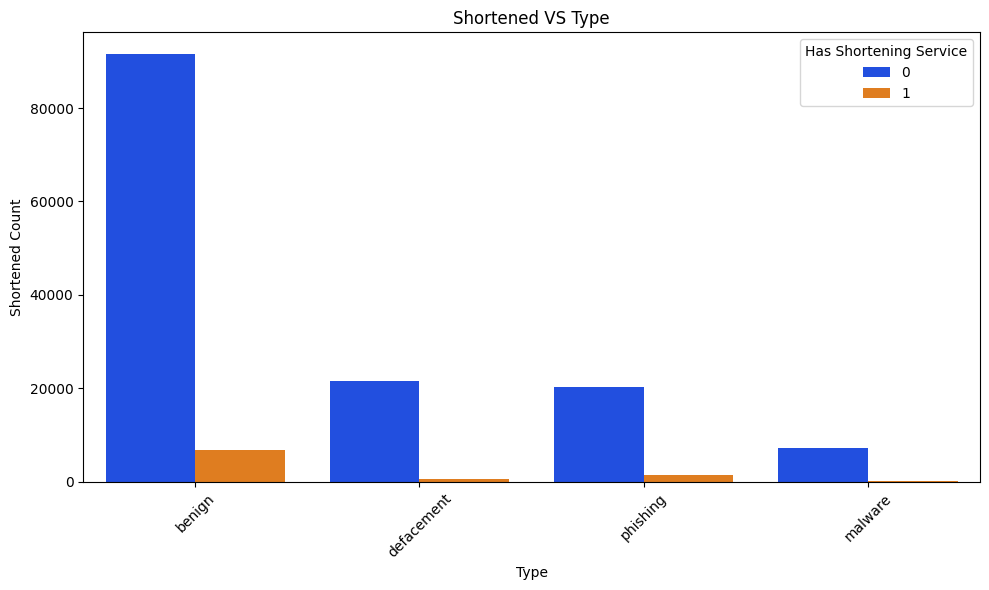

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="type", hue="shortened", palette="bright")
plt.title("Shortened VS Type")
plt.xlabel("Type")
plt.ylabel("Shortened Count")
plt.xticks(rotation=45)
plt.legend(title="Has Shortening Service")
plt.tight_layout()
plt.show()


There is a correlation with a URL being shortened and it also being benign.

In [27]:
# Prepare training data
y = df["category"]
X = df.drop(["type", "category", "url", "domain"], axis=1)

In [28]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

In [29]:
# Prepare Model and Train it
SVM_Model = SVC(gamma="auto")
SVM_Model.fit(X_train, y_train)

# Predict for train set
y_train_pred = SVM_Model.predict(X_train)

# Predict for test set
y_pred = SVM_Model.predict(X_test)

# Compute test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Test Accuracy: {test_accuracy * 100}%")
print(f"Train Accuracy: {train_accuracy * 100}%")


Test Accuracy: 86.22444444444444%
Train Accuracy: 86.63809523809523%


In [30]:
cm_svm = confusion_matrix(y_test, y_pred)

Text(50.722222222222214, 0.5, 'Actual Type')

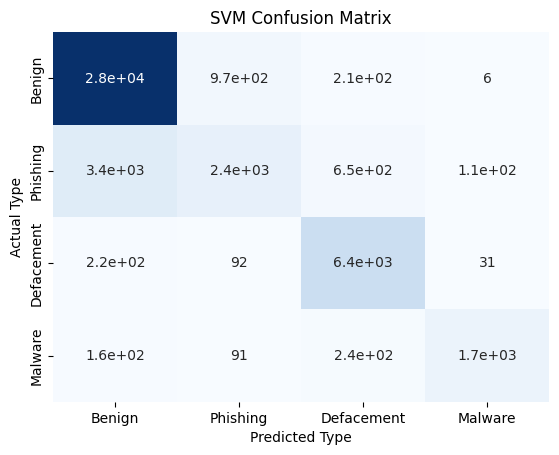

In [36]:
sns.heatmap(cm_svm, cmap="Blues", cbar=False, annot=True)
plt.xticks(np.arange(4) + 0.5, ["Benign", "Phishing", "Defacement", "Malware"])
plt.yticks(np.arange(4) + 0.5, ["Benign", "Phishing", "Defacement", "Malware"])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("Actual Type")


In [38]:
# 0 = Benign
# 1 = Phishing
# 2 = Defacement
# 3 = Malware
report = classification_report(y_test, y_pred, output_dict=True)
final_report = pd.DataFrame(report).transpose()
final_report

,precision,recall,f1-score,support
0,0.881515,0.959847,0.919015,29462.000000
1,0.676148,0.365338,0.474365,6572.000000
2,0.852540,0.948394,0.897916,6724.000000
3,0.923240,0.777877,0.844348,2242.000000
accuracy,0.862244,0.862244,0.862244,0.862244
macro avg,0.833361,0.762864,0.783911,45000.000000
weighted avg,0.849272,0.862244,0.847203,45000.000000


In [33]:
# Compute true/false positive/negative rates
FP = cm_svm.sum(axis=0) - np.diag(cm_svm)
FN = cm_svm.sum(axis=1) - np.diag(cm_svm)
TP = np.diag(cm_svm)
TN = cm_svm.sum() - (FP + FN + TP)

data = {
    "Type": ["Benign", "Phishing", "Defacement", "Malware"],
    "False Positives": FP,
    "False Negatives": FN,
    "True Positives": TP,
    "True Negatives": TN,
}

rates = pd.DataFrame(data)

# True positive rate
rates["TPR"] = rates.apply(
    lambda row: row["True Positives"]
    / (row["True Positives"] + row["False Negatives"]),
    axis=1,
)

# True negative rate
rates["TNR"] = rates.apply(
    lambda row: row["True Negatives"]
    / (row["True Negatives"] + row["False Positives"]),
    axis=1,
)

# Precision or positive predictive value
rates["Precision"] = rates.apply(
    lambda row: row["True Positives"]
    / (row["True Positives"] + row["False Positives"]),
    axis=1,
)

# Negative predictive value
rates["NPV"] = rates.apply(
    lambda row: row["True Negatives"]
    / (row["True Negatives"] + row["False Negatives"]),
    axis=1,
)

# Fall out or false positive rate
rates["NPV"] = rates.apply(
    lambda row: row["False Positives"]
    / (row["False Positives"] + row["True Negatives"]),
    axis=1,
)

# False negative rate
rates["FNR"] = rates.apply(
    lambda row: row["False Negatives"]
    / (row["True Positives"] + row["False Negatives"]),
    axis=1,
)

# False discovery rate
FDR = FP / (TP + FP)
rates["FDR"] = rates.apply(
    lambda row: row["False Positives"]
    / (row["True Positives"] + row["False Positives"]),
    axis=1,
)

rates.head()


,Type,False Positives,False Negatives,True Positives,True Negatives,TPR,TNR,Precision,NPV,FNR,FDR
0,Benign,3801,1183,28279,11737,0.959847,0.755374,0.881515,0.244626,0.040153,0.118485
1,Phishing,1150,4171,2401,37278,0.365338,0.970074,0.676148,0.029926,0.634662,0.323852
2,Defacement,1103,347,6377,37173,0.948394,0.971183,0.852540,0.028817,0.051606,0.147460
3,Malware,145,498,1744,42613,0.777877,0.996609,0.923240,0.003391,0.222123,0.076760


## Results
Interpreting the final report shows a precision of 92% for Malware meaning that the model is certain a URL is Malware 92% of the time. The next highest precision is Benign URLs with an 88% precision. Recall represents the detection rate of the model i.e. how many of the True Positives were detected by category. For recall, the leading 2 are Benign and Defacement with 96% and 94.8% respectively. F1-score represents an average between precision and recall and represents a scaled accuracy between the types. Here, Benign is the leader with 91.9% accuracy followed closely by Defacement with 89.8% and Malware with 84.4%. Phishing showed the worst overall performance with a F1-score of 47.4%.

Interpreting this matrix, we can see that Benign URLS had the highest chance of being correctly identified at 96% recall rate followed by Defacement at 94.8%. Additionally, our classification heuristics correctly identified a URL not being malware with a true negative rate of 99.7%. The weakest performance was from Phishing with a 36.5% True positive rate followed by Malware's TPV. The bulk of the misidentification in the case of Phishing was from false negatives. Phishing had the highest false negative rate of 63% followed by malware of 22%. Defacement and Benign types had a comparatively insignificant FNR of about 4-5%. The highest negative predictive value was Benign which means that the model is most confident when describing a URL as not Benign.

## References
https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset

https://www.kaggle.com/code/salemjadroun/malicious-urls-machine-learning-with-91-46-acc/notebook
